# Introduction to data structures in xarray

Now that you have learned a bit of basics about raster data and how to create a simple 2-dimensional raster array using `numpy`, we continue to explore in a more comprehensive manner how to work with real-world raster data using `xarray` and `rioxarray` libraries (+ other relevant libraries linked to them). The `xarray` library is a highly useful tool for storing, representing and manipulating raster data, while `rioxarray` provides various raster processing (GIS) capabilities on top of the `xarray` data structures, such as reading and writing several different raster formats and conducting different geocomputational tasks. Under the hood, `rioxarray` uses another Python library called `rasterio` (that works with N-dimensional `numpy` arrays) but the benefit of `xarray` and `rioxarray`is that they provide easier and more intuitive way to work with raster data layers, in a bit similar manner as working with vector data using `geopandas`. 

When working with raster data, you typically have various layers that represent different geographical features of the world (e.g. elevation, temperature, precipitation etc.) and this data is possibly captured at different times of the year/day/hour, meaning that you may have longitudinal (repetitive) observations from the same area, constituting time series data. More often than not, you need to combine information from these layers to be able to conduct meaningful analysis based on the data, such as do a weather forecast. One of the greatest benefits of `xarray` is that you can easily store, combine and analyze all these different layers via a single object, i.e. a `Dataset`.

## Key xarray datastructures: Dataset and DataArray 

The two fundamental data structures provided by the `xarray` library are `DataArray` and `Dataset` (Figure 7.2). Both of them build upon and extend the strengths of `numpy` and `pandas` libraries. The `DataArray` is a labeled N-dimensional array that is similar to `pandas.Series` but works with raster data (stored as `numpy` arrays). The `Dataset` then again is a multi-dimensional in-memory array database that contains multiple `DataArray` objects. In addition to the variables containing the observations of a given phenomena, you also have the `x` and `y` coordinates of the observations stored in separate layers, as well as metadata providing relevant information about your data, such as Coordinate Reference System and/or time. Thus, a `Dataset` containing raster data is very similar to `geopandas.GeoDataFrame` and actually various `xarray` operations can feel very familiar if you have learned the basics of `pandas` and `geopandas` covered in Chapters 3 and 6. 


![_**Figure 7.2.** Key `xarray` data structures. Image source: Xarray Community (2024), licensed under Apache 2.0._](../img/xarray-dataset-diagram.png)

_**Figure 7.2.** Key `xarray` data structures. Image source: [Xarray Community](https://tutorial.xarray.dev/fundamentals/01_data_structures.html) (2024), licensed under Apache 2.0._

Some of the benefits of `xarray` include:

- A more intuitive and user-friendly interface to work with multidimensional arrays (compared e.g. to `numpy`)
- The possibility to select and combine data along a dimension across all arrays in a `Dataset` simultaneously
- Compatibility with a large ecosystem of Python libraries that work with arrays / raster data
- Tight integration of functionalities from well-known Python data analysis libraries, such as `pandas`, `numpy`, `matplotlib`, and `dask`

In the following, we will continue by introducing some of the basic functionalities of the `xarray` data structures.

## Reading a file into Dataset

We start by investigating a simple elevation dataset using `xarray` that represents a Digital Elevation Model (DEM) of Kilimanjaro area in Tanzania. To read a raster data file (such as GeoTIFF) into `xarray`, we can use the  `.open_dataset()` function. Here, we read a `.tif` file directly from a cloud storage space that we have created for this book. By importing the `rioxarray` library, we can extend the functionalities of the `xarray` and use the `engine="rasterio"` parameter when reading the data. This is beneficial because it supports various GIS functionalities related to Coordinate Reference System management and metadata that would not be available otherwise. We can for example specify that the `masked` parameter is `True` which will take into consideration possible NoData values in the data and mask them out by setting the NoData values as NaN:

In [1]:
import xarray as xr
import rioxarray

bucket_url = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS"
url = bucket_url + "/elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"
url = "data/temp/kilimanjaro_elevation.tif"

data = xr.open_dataset(url, engine="rasterio", masked=True)
data

<xarray.Dataset> Size: 52MB
Dimensions:      (band: 1, x: 3601, y: 3601)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 52MB ...

In [2]:
type(data)

xarray.core.dataset.Dataset

Now we have read the GeoTIFF file into an `xarray.Dataset` data structure which we stored into a variable `data`. The `Dataset` contains the actual data values for the raster cells, as well as other relevant attribute information related to the data:

- `Dimensions` show the number of `bands` (in our case 1), and the number of cells (3601) on the `x` and `y` axis
- `Coordinates` is a container that contains the actual `x` and `y` coordinates of the cells, the Coordinate Reference System information stored in the `spatial_ref` attribute, and the `band` attribute that shows the number of bands in our data.
- `Data variables` contains the actual data values of the cells (e.g. elevations as in our data)

Because our `Dataset` only consists of a single `band` (i.e. the elevation values), it might make sense to reduce the dimensions of our dataset by dropping the `band` attribute because it is not really providing any useful information for us. We can subset our data and remove a specific dimension from our data by using the `.squeeze()` method. In the following, we drop the `"band"` dimension:

In [3]:
data = data.squeeze("band", drop=True)
data

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 52MB ...

As a result, now the `Dimensions` and `Coordinates` only shows the data for `x` and `y` axis, meaning that the unnecessary data was successfully removed. An alternative way to deal with this issue is to use `band_as_variable=True` parameter directly when reading the raster file with `xr.open_dataset()`:

In [4]:
xr.open_dataset(url, engine="rasterio", masked=True, band_as_variable=True)

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_1       (y, x) float32 52MB ...
Attributes:
    Band_1:         Band 1
    long_name:      Band 1
    AREA_OR_POINT:  Area

## Renaming data variables

To make the data more intuitive to use, we can also change the name of the data variable from `band_data` into `elevation`. In this way, it is more evident what our data is about. We can easily change the name of an attibute by using the `.rename()` method as follows which wants a dictionary with syntax `{"old_name": "new_name"}`:

In [5]:
data = data.rename({"band_data": "elevation"})
data

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float32 52MB ...

Now the name of our data variable was changed to `elevation` which makes it more intuitive and convenient to use than calling the variable with a very generic name `band_data`.

## Plotting a data variable

Thus far, we have investigated how the `xarray` data structures look like. However, we have not yet plotted anything on a map, which is also one of the typical things that you want to do as one of the first steps whenever working with new data. The `xarray` library provides very similar plotting functionality as `geopandas`, i.e. you can easily create a visualization out of your `DataArray` objects by using the `.plot()` method that uses `matplotlib` library in the background. In the following, we create a simple map out of the `"elevation"` data variable: 

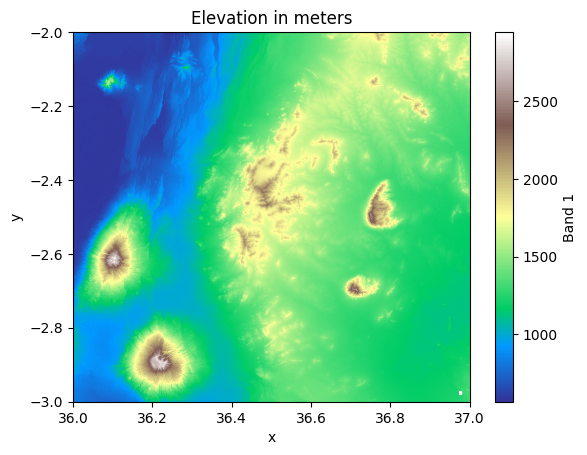

In [6]:
import matplotlib.pyplot as plt

# Plot the values
mesh = data["elevation"].plot(cmap="terrain")

# Add a title
plt.title("Elevation in meters");

_**Figure 7.3.** A map representing the elevation values in the Kilimanjaro area._

Great! Now we have a nice simple map that shows the relative height of the landscape where the highest peaks of the mountains are clearly visible on the bottom left corner. Notice that we used the `"terrain"` as a colormap for our visualization which provides a decent starting point for our visualization. However, as you can see it does not make sense that the part of the elevations are colored with blue because the land surface in this area of the world should not have any values going below the sea surface (0 meters). It is possible to deal with this issue by adjusting the colormap which you can learn from Chapter 8. 

We can also easily plot our data in a couple of different ways and e.g. produce a contour map representing the elevation using contour lines. A contour map is a type of map that represents the three-dimensional features of a landscape in two dimensions by using contour lines  highlighting the hills and valleys in our data. Each contour line connects points of equal elevation above a reference level, such as sea level. These lines provide a way to visualize the shape, slope, and elevation of the terrain. Contour maps are widely applied to different data in various domains, such as in navigation and orienteering to visualize elevation characteristics to help activities such as hiking; in meteorology to visualize weather related phenomena (atmospheric pressure, temperature); and in hydrology to help identifying drainage patterns, watersheds, and potential flood zones.  We can create a contour map based on the input data by calling the `.plot.contour()` method in `xarray`:

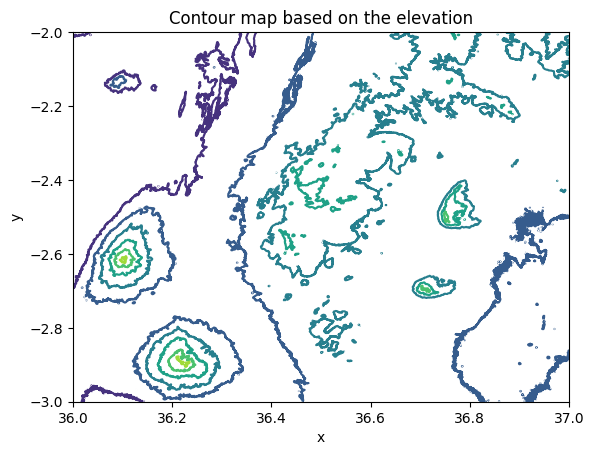

In [7]:
contours = data["elevation"].plot.contour()
plt.title("Contour map based on the elevation");

_**Figure 7.4.** A contour map representing the elevation values in the Kilimanjaro area._

It is also possible to create a surface map that shows the elevation values in 3D. A 3D surface map is a three-dimensional representation of a terrain or surface, created by plotting elevation or depth data as a continuous surface. The map visually depicts the topography by assigning different colors, shading, and heights to represent variations in elevation, providing a realistic and intuitive view of the terrain. Creating a 3D surface map can be done by calling the `.plot.surface()` method in `xarray`:

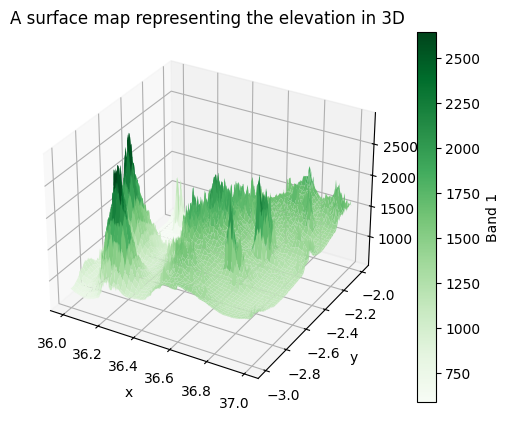

In [8]:
surface = data["elevation"].plot.surface(cmap="Greens")
plt.title("A surface map representing the elevation in 3D");

_**Figure 7.5.** A 3D surface map representing the elevation values in the Kilimanjaro area._

Now we have a nice three dimensional map that clearly shows the hills and valleys in our study region that gives an intuitive view to the landscape in the given region.

## Extracting basic raster dataset properties

Now as we have explored our data visually, it is good to continue by examining the basic properties of the data, as well as by calculating summary statistics out of the data, such as the minimum,  maximum, or mean values of your data. To extract this information from your `Dataset`, `xarray` provides very similar functionalities as `pandas` to compute some basic statistics out of your data. For instance, we can easily extract the maximum elevation of our data by calling `.max()` method:

In [9]:
data["elevation"].max()

<xarray.DataArray 'elevation' ()> Size: 4B
array(2943., dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

As we see, this produces quite a lot of information because `xarray` returns an `DataArray` as a result by default. When exploring the output, we can see that the single value in the array is `2943` which is the highest point in our data. However, typically it would be more useful to get a numerical value as a result when doing operations like these. Luckily, it is easy to extract the actual number from the data by adding `.item()` after the command. The `.item()` method returns the `xarray.Dataset` element as a regular Python scalar value which is more similar to what e.g. `pandas` returns when you call the `.max()` or `.min()`, as demonstrated below: 

In [10]:
data["elevation"].min().item()

568.0

In [11]:
data["elevation"].max().item()

2943.0

### Dimensions of the data

In addition to the summary statistics, we can explore some of the basic properties of our raster data. Majority of the geographic data related properties of a raster `Dataset` can be accessed via `.rio` {term}`accessor`. An accessor is a method or attribute added to an existing data structure, such as a `DataArray` or `Dataset` in `xarray`, to provide specialized functionality. Accessors extend the capabilities of the base object without modifying its core structure. Via the `.rio` accessor we can explore various attributes of our data, such as the `.shape`, `.width` or `.height`:

In [12]:
print(data.rio.shape)
print(data.rio.width)
print(data.rio.height)

(3601, 3601)
3601
3601


### Spatial resolution

From the outputs we can see that the shape of our raster data seems to be rectangular as we have 3601 X 3601 cells to each direction (x and y). To better understand the data in geographic terms, we can retrieve the *{term}`spatial resolution`* of the data by calling the `.rio.resolution()` method:

In [13]:
data.rio.resolution()

(0.0002777777777777778, -0.0002777777777777781)

As we see, the spatial resolution, i.e. the size of a single cell in our raster layer is ~0.0028. The resolution is always reported in the units of the input dataset's *{term}`coordinate reference system`* (CRS). Thus, in our case, this number is reported in *{term}`decimal degrees`* meaning that the resolution is 30 meters. 

### Coordinate reference system

We can easily access the coordinate reference system (CRS) information of our raster dataset via the `.rio.crs` attribute:

In [14]:
data.rio.crs

CRS.from_epsg(4326)

The `.rio.crs` returns the coordinate reference system information as an *{term}`EPSG code`* and the code `4326` stands for the WGS84 coordinate reference system in which the units are represented as latitudes and longitudes (i.e. decimal degrees). Another CRS-related attribute that is useful to know is *{term}`transform`*. The transform refers to the affine transformation matrix that maps pixel coordinates to geographic coordinates. It defines how the raster data is aligned in space, including information on scaling, rotation, and translation relative to a coordinate reference system. You can access the `transform` attribute as follows:

In [15]:
data.rio.transform()

Affine(0.0002777777777777778, 0.0, 35.9998611111111,
       0.0, -0.0002777777777777781, -1.99986111111111)

### Spatial extent

To extract information about the *{term}`spatial extent`* of the dataset, we can use the `.rio.bounds()` method:

In [16]:
data.rio.bounds()

(35.9998611111111, -3.000138888888889, 37.000138888888884, -1.99986111111111)

This returns the minimum and maximum coordinates (here, in latitude and longitude) that bound our dataset, forming a minimum bounding rectangle around the data. The first two numbers represent the left-bottom (x,y) corner of the dataset, while the last two number represent the right-top corner (x,y) of the area, respectively. 

### NoData value

Did you notice a small white rectangle in the bottom-right corner in Figure 7.3? This white area exists because our dataset includes some cells that does not have any data, i.e. they are represented with `NaN` values. To investigate whether your data contains `NaN` values, you can access the NoData value of the `DataArray` as follows:

In [17]:
data["elevation"].rio.nodata

nan

The `.rio.nodata` returns the value how the NaN value is represented in our `xarray.DataArray`. As we can see, the NaN value is represented with `numpy` library's `nan`. However, in many cases, the NoData value in a given raster file is actually coded with a specific numerical value that is a clear outlier compared to the rest of the data, such as `-9999` or `9999`. To find out what value has been used in the raster file to code the NoData value, we can use `rio.encoded_nodata` which returns the NoData value as it is represented in the actual source data: 

In [18]:
data["elevation"].rio.encoded_nodata

9999.0

It is important to deal with possible NaN values in the data, because otherwise the NoData values would be presented as actual values in the dataset (i.e. elevation). In our case, we dealt with the NaN values already when reading the data into `xarray` with `xr.open_dataset()` by specifying `masked=True`. This ensured that all values with number `9999` in the raster were transformed into `numpy.nan` values. This ensures that they do not influence any of the calculations when using the data but they are properly treated as data that does not exist. For example, the maximum value that we extracted earlier from the data was `2943`, not `9999` which would be the case unless we mask out the NaN values when reading the data. 

If a given dataset contains NoData values (it does not necessarily contain any NoData), the metadata of the dataset should always contain information about how the NoData values are encoded. With some raster files, you can also search for the NoData value by checking the `.attrs` attribute that might include information about NoData and is returned as a Python dictionary. The information about NoData can be can be stored with different keys, and you should look for values stored in keys, such as `_FillValue`, `missing_value`, `fill_value` or `nodata`. In our raster file, this metadata has not been stored as part of the file, and thus, we cannot access the `.attrs` attribute:

In [19]:
data["elevation"].rio.attrs

AttributeError: 'RasterArray' object has no attribute 'attrs'

### Radiometric resolution (bit depth)

Lastly, we can extract information about the *{term}`radiometric resolution`* (i.e. bit depth) of our `Dataset` by calling `.dtypes`:

In [20]:
data.dtypes

Frozen({'elevation': dtype('float32')})

This returns a Python dictionary like object that provides information about the bit depth of each `DataArray` stored in our `Dataset`. In our case, we only have one data attribute (elevation) and from the result we can see that the bit depth of this data is 32 bits. The radiometric resolution is determined by the number of bits used to represent the data for each pixel, which defines the range of possible intensity values. For example, an 8-bit sensor can record 256 levels of intensity (values 0-255), while a 16-bit sensor can record 65536 levels. Thus, the more bits you use to store the numbers on computer, the larger numbers you can store with a given bit depth. Notice that the more bits you use to store the numbers, the higher the memory consumption is as well. In terms of our example here (32-bit float), the data can be stored with high precision as it allows to store numbers with many decimals (approximately 7 decimal digits). 

Another useful thing to understand about computer systems is that the numbers can be represented as either signed or unsigned, which determines whether negative values can be stored. Signed numbers include a "+" or "-" sign to indicate whether the value is positive or negative, while unsigned numbers are limited to non-negative values. The sign and bit depth (8-bit, 16-bit, etc.) directly affect the range of values that can be represented in the raster. For example, an 8-bit signed integer can represent values from -128 to 127, while an 8-bit unsigned integer can represent values from 0 to 255. Thus, if your data only contains positive numbers, it makes sense to store the data as unsigned because then you can store larger numbers with the same number of bits. For instance, Landsat 8 satellite sensor data are stored as unsigned 16-bit values meaning that the possible values are from 0 to 65536. The data type (signed, unsigned) can also significantly influence the memory footprint of your data which we will cover next.

### Size of the data: Memory footprint in bytes

We can extract information about the memory footprint of our `DataArray` or `Dataset` via the `.nbytes` attribute which returns the total bytes consumed by the stored data. For convenience, we convert the bytes into Megabytes (MB) with formula `<bytes> / (1000*1000)` where the value 1000 converts the bytes into kilobytes and the second one converts the kilobytes into megabytes, respectively:

In [21]:
# Memory consumption of a single DataArray
bytes_to_MB = 1000 * 1000
footprint_MB = data["elevation"].nbytes / bytes_to_MB
print(f"DaraArray memory consumption: {footprint_MB:.2f} MB.")

DaraArray memory consumption: 51.87 MB.


In [22]:
# Memory consumption of the whole Dataset
footprint_MB = data.nbytes / bytes_to_MB
print(f"Dataset memory consumption: {footprint_MB:.2f} MB.")

Dataset memory consumption: 51.93 MB.


As we can see from the above, the memory consumption of the `elevation` data variable is 51.87 megabytes while the memory consumption of the whole `Dataset` is slightly larger (51.93 MB). Majority of the memory footprint of a `Dataset` goes to storing the data variables (here, elevation values) and the rest of the memory is mostly consumed by other metadata related to the data (coordinates, CRS, indices etc.). Thus, the more data variables you store in your `Dataset` the larger the overall memory footprint of the data will be. 

### Converting data type (bit depth)

Now we know that our data consumes quite a bit of memory from our computer. However, in certain cases there might be ways to optimize the memory usage by changing the data type (i.e. bit depth) into a type that is not as memory-hungry as the 32-bit float. For example our elevation data is presented with whole numbers which is evident e.g. from the minimum and maximum values of our data, which were `568.0` and `2943.0` respectively. Notice that neither of these values have any decimals (other than 0), which is due to the fact the precision of our elevation data is in full meters. Thus, the type of our elevation data could be changed to integers. In fact, we could use {term}`unsigned integer` as a data type because the elevation values present in the data fall under the range of 0-65535. Notice that if our data values would exceed these limits, we could use 32-bit or 64-bit integer data types which allow to store much higher numbers in the array. 

But does the bit-depth matter really? It does. For example in our case it would make a lot of sense to store the data with lower bit depth because that requires less disk space and memory from the computer as we demonstrate in the following. To change a data type of our elevation data variable, we can use the `.astype()` method that converts the input values into the target data type which is provided as an input argument. In the following, we will convert the elevation values (32-bit floats) into 16-bit unsigned integer numbers by calling `.astype("uint16")`. 

In [23]:
# Convert the data into integers
data16 = data.copy()
data16["elevation"] = data16["elevation"].astype("uint16")

/Users/tenkanh2/micromamba/envs/python-gis-book/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Oops, the `xarray` is producing a warning for us here. The reason for the warning is because our data contains `NaN` values which are incompatible with the integer data type. NaN values are only supported by float data types, thus to get rid off this warning, you should fill the NaN values with some meaningful number before doing the conversion to integers. By default, the data type conversion will replace the NaN values with value 0. There are different approaches to deal with this issue (e.g. interpolation), but for now, we will just ignore this warning for the sake of simplicity. 

We can check the memory consumption of our updated `DataArray` as follows:

In [24]:
# Memory consumption of the updated DataArray
footprint_MB = data16["elevation"].nbytes / bytes_to_MB
print(f"DaraArray memory consumption: {footprint_MB:.2f} MB.")

DaraArray memory consumption: 25.93 MB.


In [25]:
data16["elevation"].max().item()

2943

As we can see from the above the maximum elevation was now changed from the decimal number (2943.0) into integer (2943). Also the memory consumption improved significantly as the size of our data was cut into half when we converted the data into 16-bit unsigned integers. Thus, by choosing the data type in a smart way, you can significantly lower the memory consumption of the data on your computer which might make a big difference in terms of performance of your analysis. This is especially true in case you are analyzing very large raster datasets. In the following, we can see how changing the data type influences on the memory footprint of the data. Now we use `float` data types in the conversions so that we don't receive the "invalid value" warning as before:

In [26]:
print(
    "Memory consumption 16-bit:",
    data["elevation"].astype("float16").nbytes / bytes_to_MB,
    "MB.",
)
print(
    "Memory consumption 32-bit:",
    data["elevation"].astype("float32").nbytes / bytes_to_MB,
    "MB.",
)
print(
    "Memory consumption 64-bit:",
    data["elevation"].astype("float64").nbytes / bytes_to_MB,
    "MB.",
)

Memory consumption 16-bit: 25.934402 MB.
Memory consumption 32-bit: 51.868804 MB.
Memory consumption 64-bit: 103.737608 MB.


As we can see, the memory consumption of the same exact data varies significantly depending on the bit-depth that we choose to use for our data. It is important to be careful when doing bit-dept conversions that you do not sabotage your data with the data conversion. For example, in our data the value range is between 568-2943. Thus, we need to use at least 16-bits to store these values. However, nothing stops you from changing the data type into 8-bit integers which will significantly alter our data:

In [27]:
low_bit_depth_data = data["elevation"].astype("uint8")
print("Min value: ", low_bit_depth_data.min().item())
print("Max value: ", low_bit_depth_data.max().item())

Min value:  0
Max value:  255


/Users/tenkanh2/micromamba/envs/python-gis-book/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


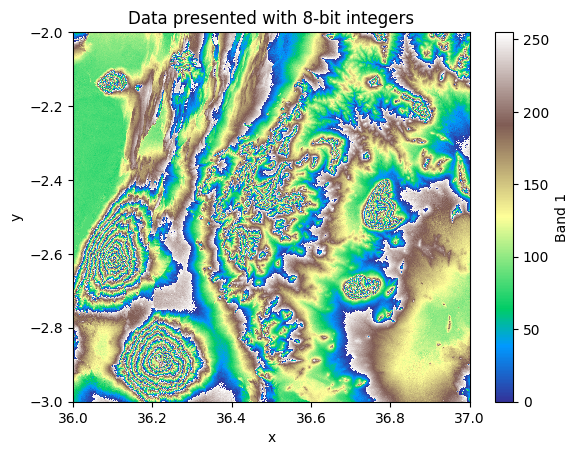

In [28]:
low_bit_depth_data.plot(cmap="terrain")
plt.title("Data presented with 8-bit integers");

_**Figure 7.6.** Elevation values represented as 8-bit integers with distorted values._

As we can see from the map, the result distorts the data significantly and ultimately makes it unusable because all the cells having a value larger than 255 (i.e. the maximum supported value with 8-bits) are incorrectly presented in the data. Thus, when doing data type conversions, it is good to be extra careful that you do not accidentally break your data and produce incorrect results when further analyzing it. 

## Creating a new data variable

At the moment, we only have one data variable in our `Dataset`, i.e. the `elevation`. As a reference to vector data structures in `geopandas` library which we introduced in Chapter 6, this would correspond to a situation in which you would have a single column in your `GeoDataFrame`. However, it is very easy create new data variables into your `Dataset` e.g. based on specific calculations or data conversions. For instance, we might be interested to calculate the relative height (i.e. relief) based on our data which tells how much higher the elevations (e.g. the highest peak) are relative to the lowest elevation in the area. This can be easily calculated by subtracting the lowest elevation from the highest elevation in an area. In the following, we create a new data variable called `"relative_height"` into our `Dataset` based on a simple mathematical calculation. You can create new data variables into your `Dataset` by using square brackets and the name of your variable as a string (e.g. `data["THE_NAME"]`), as follows:

In [29]:
min_elevation = data["elevation"].min().item()

# Calculate the relief
data["relative_height"] = data["elevation"] - min_elevation
data

<xarray.Dataset> Size: 104MB
Dimensions:          (x: 3601, y: 3601)
Coordinates:
  * x                (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0
  * y                (y) float64 29kB -2.0 -2.0 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref      int64 8B 0
Data variables:
    elevation        (y, x) float32 52MB 826.0 826.0 ... 1.301e+03 1.305e+03
    relative_height  (y, x) float32 52MB 258.0 258.0 255.0 ... 733.0 733.0 737.0

As a result, we now can see that a new data variable called `"relative_height"` was created and stored into our `Dataset`. All of the data variables stored in a `Dataset` are of type `DataArray` which is the N-dimensional array as we discussed at the beginning of this section. We can confirm the data type of our data variable by typing: 

In [30]:
type(data["elevation"])

xarray.core.dataarray.DataArray

Ultimately, you can store as many data variables to your dataset as you like. In case you are interested to explore all the data variables that are presented in your `Dataset`, you can do this by calling `.data_vars` attribute as follows: 

In [31]:
data.data_vars

Data variables:
    elevation        (y, x) float32 52MB 826.0 826.0 ... 1.301e+03 1.305e+03
    relative_height  (y, x) float32 52MB 258.0 258.0 255.0 ... 733.0 733.0 737.0

Here, we can see the names of the data variables, as well as some basic information about the data itself including the data type, size of the data in MiB, and a snippet of the actual values in the `DataArrays`. In case you are only interested to find out the names of the data variables, you can extract them as a list as follows:

In [32]:
list(data.data_vars)

['elevation', 'relative_height']

## Writing to a file

At this stage, we have learned how to read raster data and explored some of the basic properties of a raster `Dataset`. As a last thing, we will learn how to write the data from `xarray` into specific raster file formats. Similarly as with vector data, raster data can be stored in various formats. 

### Raster file formats

Table 7.1 introduces some of the popular file formats used for storing raster data. The `GeoTIFF` format is one of the most widely used formats to store individual raster layers (i.e. a single `DataArray`) to disk which is widely used format in various GIS software. One flavor of `GeoTIFF` that is useful to know is a `Cloud Optimized GeoTIFF` (`COG`) which is a regular `GeoTIFF` file with an internal organization that enables more efficient workflows on the cloud (useful with large datasets). With `COG` files you can stream just the portion of data that is needed that can significantly reduce processing times and allow working with a single large `GeoTIFF` file instead of multiple tiles. 


: _**Table 7.1**. Common raster file formats._

| Name    | Extension   | Description                                                                                        |
|:-------:|:-----------:|:---------------------------------------------------------------------------------------------------|
| GeoTiff | .tif, .tiff | Widely used to store individual raster layers to disk (i.e. a single `xarray.DataArray`).          |
| netCDF  | .nc         | Widely used to store a whole `xarray.Dataset` that can contain multiple variables.                 |
| Zarr    | .zarr       | Newer format for storing `xarray.Dataset`. Supports storing large data in compressed chunks.       |


The `netCDF` format is also widely used in geosciences for storing multiple variables into a single file which is based on a general-purpose file format and a data model called `HDF5` (`.h5`). The `Zarr` file format is a newer format designed for cloud-native, chunked, and compressed array storage. The `Zarr` file format and the associated `zarr` library also allows you to write multiple variables (i.e. a whole `xarray.Dataset`) into a single `.zarr` directory/file in a similar manner as with `netCDF`. In addition, `zarr` has the ability to store arrays in various ways, including in memory, in files, and in cloud-based object storage (such as Amazon S3 buckets or Google Cloud Storage) that are often used to store very large datasets. When using `.zarr` file format, you can take advantage of the nice capabilities of `Zarr`, including the ability to store and analyze datasets far too large fit onto disk, particularly in combination with `dask` library which provides capabilities for parallel and distributed computing. 

### Raster compression methods

When working with large raster datasets, managing storage space and improving performance are essential. Raster compression methods can help you to reduce the file size of raster data which can often take up significant disk space. Compression can also speed up your analysis process because compressed files are faster to read, download and transfer (online). Thus, when working with `rioxarray` and writing data to different file formats, it is useful to compress the data. Thus, knowing which compression method to choose when saving raster data in formats like `GeoTIFF` is essential. 

The data compression can be *{term}`lossless <lossless compression>`* or *{term}`lossy <lossy compression>`*. Lossless compression means that the file size is reduced without losing or changing any data, while lossy compression achieves higher compression rate (i.e. smaller file size) with some loss in data quality / precision. Table 7.2 introduces some of the most widely used compression methods that can be used when writing raster data. Choosing the "right" compression method depends on different factors. If you need lossless compression, `LZW` or `ZSTD` is a good balance between size and speed. If storage space is a top priority, you can consider using `JPEG` or `JPEG2000` but it is good to be aware of the potential data loss. For cloud-based workflows, `ZSTD` or `DEFLATE` are good choices for compression.


: _**Table 7.2**. Common raster compression methods._

| Name      | Type        | Compress Ratio | Encoding Speed | Decoding Speed | Common Raster Formats   | Best For                                     |
|-----------|-------------|----------------|----------------|----------------|-------------------------|----------------------------------------------|
|`LZW`      | Lossless    | Moderate       | Medium         | Fast           | GeoTIFF, PNG            | General-purpose datasets, GIS workflows      |
|`DEFLATE`  | Lossless    | High           | Slow           | Medium         | GeoTIFF, PNG            | Archival storage, cloud-based processing     |
|`ZSTD`     | Lossless    | High           | Fast           | Fast           | Cloud-optimized GeoTIFF | Cloud storage, high-performance applications |
|`JPEG`     | Lossy       | Very High      | Fast           | Fast           | JPEG, GeoTIFF (YCbCr)   | Web visualization, aerial imagery            |
|`JPEG2000` | Both avail. | Very High      | Slow           | Medium         | JP2, GeoTIFF (JP2)      | High-resolution satellite imagery            |


### GeoTIFF

In the following, we will see how to write data into all of these data formats. When writing data into `GeoTIFF` format you can use the `.rio.to_raster()` method that comes with the `rioxarray` library. As mentioned earlier, `GeoTiff` only allows you to write a single `DataArray` at a time into a file:

In [33]:
data["elevation"].rio.to_raster("data/temp/elevation.tif")
data["relative_height"].rio.to_raster("data/temp/relative_height.tif")

As we saw at the beginnig of this section, to read a `GeoTIFF` file, you can use the `xr.open_dataset()` with engine `"rasterio"`:

In [34]:
xr.open_dataset("data/temp/relative_height.tif", engine="rasterio", masked=True)

<xarray.Dataset> Size: 52MB
Dimensions:      (band: 1, x: 3601, y: 3601)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 52MB ...

### Cloud Optimized GeoTIFF (COG)

You can write ...

In [37]:
data["elevation"].rio.to_raster("data/temp/elevation_cog.tif", driver="COG", compress="LZW")
data["relative_height"].rio.to_raster("data/temp/relative_height_cog.tif", driver="COG", compress="LZW")

In [36]:
xr.open_dataset("data/temp/elevation_cog.tif", engine="rasterio", masked=True)

<xarray.Dataset> Size: 52MB
Dimensions:      (band: 1, x: 3601, y: 3601)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 52MB ...

### netCDF

With `netCDF` format you can write (and read) a whole `xarray.Dataset` at a time which can be very convenient especially when you have multiple relevant variables that you want to store. When saving a `Dataset` to `netCDF`, you can use the `.to_netcdf()` method of `xarray`:

In [ ]:
netcdf_fp = "data/temp/kilimanjaro_dataset.nc"
data.to_netcdf(netcdf_fp)

To read the `netCDF` file, you can use `xarray.open_dataset()` method that picks the correct file format based on the file extension. Here, it is important to use the parameter `decode_coords="all"` to ensure that the metadata (CRS information) is also read appropriately:

In [ ]:
ds = xr.open_dataset(netcdf_fp, decode_coords="all")
ds

### Zarr

To write the data into `Zarr` file format, you can use the `.to_zarr()` method. To be able to write to `Zarr` format you need to have `zarr` Python library. Here, we write our dataset using writing `mode="w"` which will overwrite an existing `Zarr` file if it exist:

In [ ]:
zarr_fp = "data/temp/kilimanjaro_dataset.zarr"
data.to_zarr(zarr_fp, mode="w")

To read the `Zarr` file, you can again use the `xr.open_dataset()`. Here, we specify also the `engine` to tell the `xarray` that we want specifically to read `Zarr` file format and similarly as with `netCDF` we use `decode_coords="all" to ensure that the coordinate reference system metadata is correctly read from the data:

In [ ]:
ds = xr.open_dataset(zarr_fp, engine="zarr", decode_coords="all")
ds

As mentioned earlier, `Zarr` is a useful format because it allows to write a given `Dataset` into disk by dividing the data into chunks of specific size. This can be especially useful when you have a very large `Dataset` because it allows reading and writing data in parallel which makes the process faster. To write a `Dataset` into `Zarr` using chunks, we can specify specific `encoding` settings that tells how the data should be chunked. We can do this as follows:

In [ ]:
zarr_fp = "data/temp/kilimanjaro_dataset_chunked.zarr"

# Provide the size of a single chunk per variable
encoding = {
    "elevation": {"chunks": (256, 256)},
    "relative_height": {"chunks": (256, 256)},
}

data.to_zarr(zarr_fp, mode="w", encoding=encoding)

With the `encoding` we basically told that `.to_zarr()` method that the values in `elevation` and `relative_height` variables should be sliced into chunks where each chunk has 256 x 256 items of data (i.e. raster cells).

To read the chunked `Zarr` file, we can use the `xarray.open_dataset()` function in a similar manner as before:

In [ ]:
ds = xr.open_dataset(zarr_fp, engine="zarr", decode_coords="all")
ds

If it happens that during the reading the CRS information (`spatial_ref`) is not properly read as part of the `Coordinates` information alongside with `x` and `y` coordinates (as in our case here), you can fix this as follows:

In [ ]:
ds.coords["spatial_ref"] = ds["spatial_ref"]
ds

Now the CRS information in the `spatial_ref` variable is in correct place so that the `rioxarray` functionalities work as should. We can now for example correctly access the `.crs` attribute via the `.rio` accessor:

In [ ]:
ds.rio.crs

`Zarr` file format supports many other useful functionalities to e.g. compress the data and store the data in cloud object storage. In case you are interested in these functionalities, we recommend you to read further details from the [`xarray` documentation](https://docs.xarray.dev/en/stable/user-guide/io.html#zarr) [^zarr-xarray] as well as from the [`zarr` documentation](https://zarr.readthedocs.io/)[^zarr]. 

## Footnotes

[^zarr-xarray]: <https://docs.xarray.dev/en/stable/user-guide/io.html#zarr>
[^zarr]: <https://zarr.readthedocs.io/>